In [1]:
# Tutorial/ Analysis of volume of different bins of depth, neutral density, and potential density.
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gsw
import matplotlib

In [2]:
# We shall use the most recent model years, which at the moment is 1056 to 1060
rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
datadir = 'ocean_annual_z_1x1deg/ts/annual/5yr/'
filename_age = 'ocean_annual_z_1x1deg.1056-1060.agessc.nc'
filename_temp = 'ocean_annual_z_1x1deg.1056-1060.thetao.nc'
filename_vol = 'ocean_annual_z_1x1deg.1056-1060.volcello.nc'
filename_so = 'ocean_annual_z_1x1deg.1056-1060.so.nc'

In [3]:
# Let's open up the data from these files
age = xr.open_dataset(rootdir + datadir + filename_age) # Ideal Age
temp = xr.open_dataset(rootdir + datadir + filename_temp) # Temperature
vol = xr.open_dataset(rootdir + datadir + filename_vol) #Volume
so = xr.open_dataset(rootdir + datadir + filename_so) #Salinity

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [4]:
# Neutral density calculation
def calc_sigmantr(T,S):
    '''function sigmantr = calc_sigmantr(T,S)
    CALCULATE APPROXIMATE NEUTRAL DENSITY FROM POTENTIAL TEMPERATURE AND SALINITY,
    using functional form of MacDougall and Jackett (2005)
    
    INPUT
        T    potential temperature in degrees celsius
        S    salinity in psu

    OUTPUT
        sigmantr    approximation of neutral density from empirical formula of MacDougall and Jackett (2005)

    Copied across from cdfsigntr.f90 from CDFTOOLS package by G.MacGilchrist (gmacgilchrist@gmail.com)'''
    
    dl_t = T;
    dl_s = S;
    dl_sr= np.sqrt(np.abs(dl_s));

    ### Numerator
    # T-polynome
    dl_r1=((-4.3159255086706703e-4*dl_t+8.1157118782170051e-2 )*dl_t+2.2280832068441331e-1 )*dl_t+1002.3063688892480e0;
    # S-T Polynome
    dl_r2=(-1.7052298331414675e-7*dl_s-3.1710675488863952e-3*dl_t-1.0304537539692924e-4)*dl_s;
    ### Denominator
    # T-Polynome
    dl_r3=(((-2.3850178558212048e-9*dl_t-1.6212552470310961e-7)*dl_t+7.8717799560577725e-5)*dl_t+4.3907692647825900e-5)*dl_t+1.0e0;
    # S-T Polynome
    dl_r4=((-2.2744455733317707e-9*dl_t*dl_t+6.0399864718597388e-6)*dl_t-5.1268124398160734e-4 )*dl_s;
    # S-T Polynome
    dl_r5=(-1.3409379420216683e-9*dl_t*dl_t-3.6138532339703262e-5)*dl_s*dl_sr;

    # Neutral density
    sigmantr = ( dl_r1 + dl_r2 ) / ( dl_r3 + dl_r4 + dl_r5 ) - 1000E0;
    
    return sigmantr

In [5]:
# Calculate Neutral Density
neutralden = calc_sigmantr(temp.thetao, so.so)
neutralden.name = 'neutral_density'
# Calculate Potential Density
potden = gsw.density.sigma2(so.so, temp.thetao)
lat = so.lat 
lon = so.lon
time = so.time
z_l = so.z_l
pot_den = xr.DataArray(potden, coords = [time, z_l, lat, lon ], dims = ['time', 'z_l', 'lat', 'lon'])
pot_den.name = 'potential_density'

In [6]:
ds = xr.merge([temp, age, vol, so, neutralden, pot_den])

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/num

In [7]:
def binsum(ds,variable):
    # variable and weights are strings
    variable_times_weights = ds[variable]
    volsum = variable_times_weights.sum()
    return volsum

In [8]:
# Try to sum the volume in each depth class
z_small = z_l[:34]
newdataset = ds.isel(time=0).groupby_bins('z_l', z_l, labels=z_small)
newvolsum = newdataset.apply(binsum, variable = 'volcello')
print(newvolsum)

<xarray.DataArray 'volcello' (z_l_bins: 34)>
array([3.597845e+15, 3.571319e+15, 5.319082e+15, 7.893126e+15, 8.673276e+15,
       8.601201e+15, 8.546460e+15, 1.274538e+16, 1.688507e+16, 1.678812e+16,
       2.502201e+16, 3.311278e+16, 3.287465e+16, 3.267293e+16, 3.251049e+16,
       3.236680e+16, 3.222900e+16, 3.208869e+16, 3.195426e+16, 3.181549e+16,
       3.166361e+16, 3.151142e+16, 5.477595e+16, 7.738639e+16, 1.138534e+17,
       1.465379e+17, 1.366550e+17, 1.194836e+17, 9.498131e+16, 6.568930e+16,
       3.687962e+16, 1.234683e+16, 1.782447e+15, 1.918869e+14], dtype=float32)
Coordinates:
  * z_l_bins  (z_l_bins) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03
    time      object 1056-07-02 12:00:00


Text(0, 0.5, 'Depth bins')

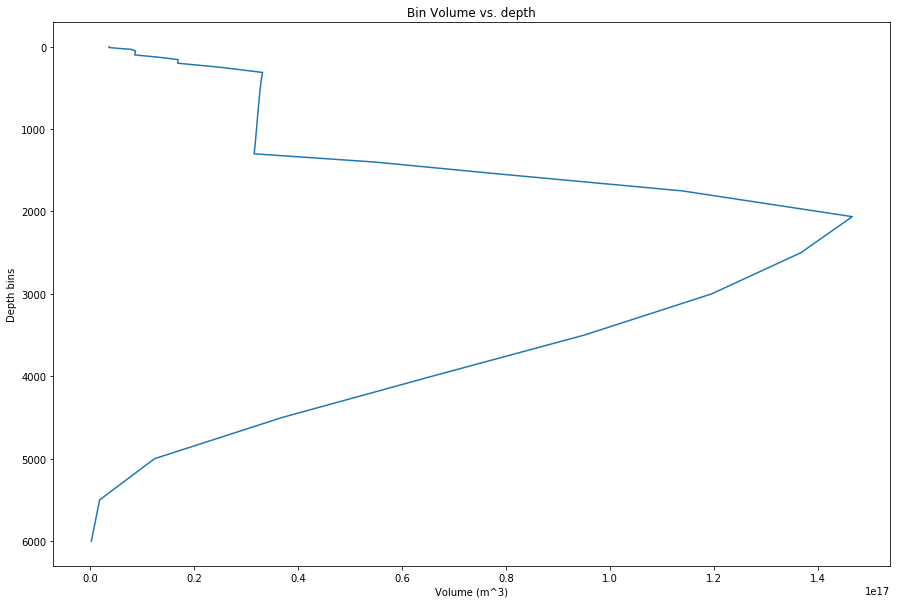

In [9]:
plt.figure(figsize = (15,10))
plt.plot(newvolsum, z_small)
plt.gca().invert_yaxis() 
plt.title('Bin Volume vs. depth')
plt.xlabel('Volume (m^3)')
plt.ylabel('Depth bins')

In [10]:
# Try to sum the volume in each neutral density class
neutralden_bins = np.arange(20, 30, 0.25)
neutralden_bins_labels = np.arange(20.125, 29.875, 0.25)
different = ds.isel(time=0).groupby_bins('neutral_density',neutralden_bins, labels = neutralden_bins_labels)
denvolsum = different.apply(binsum, variable='volcello')
print(denvolsum)

<xarray.DataArray 'volcello' (neutral_density_bins: 39)>
array([1.304506e+13, 1.526292e+13, 2.339085e+13, 4.621987e+13, 9.369832e+13,
       1.702502e+14, 6.936456e+14, 3.881879e+14, 6.807049e+14, 9.645154e+14,
       1.127920e+15, 1.327399e+15, 1.398015e+15, 1.452373e+15, 1.512487e+15,
       1.687804e+15, 1.981286e+15, 2.307823e+15, 3.055419e+15, 3.464699e+15,
       4.584219e+15, 5.866676e+15, 8.296044e+15, 1.206682e+16, 1.964969e+16,
       3.862647e+16, 5.184949e+16, 4.581614e+16, 5.319694e+16, 6.576364e+16,
       1.575065e+17, 7.045844e+17, 1.307853e+17, 1.342558e+16, 3.087043e+14,
       6.344119e+11, 2.855461e+11, 2.960866e+11, 8.715293e+11], dtype=float32)
Coordinates:
  * neutral_density_bins  (neutral_density_bins) float64 20.12 20.38 ... 29.62
    time                  object 1056-07-02 12:00:00


Text(0, 0.5, 'Neutral Density bins (kg/m^3)')

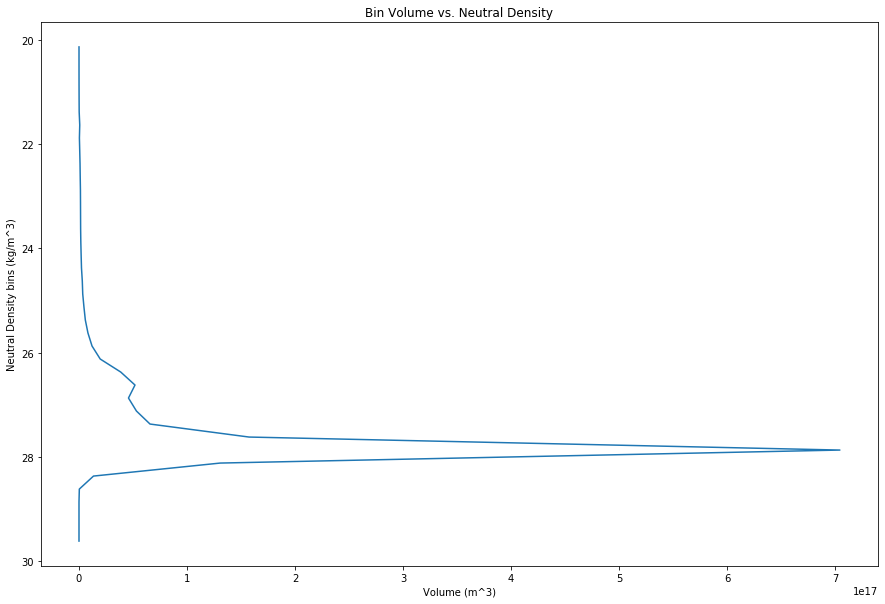

In [11]:
plt.figure(figsize = (15,10))
plt.plot(denvolsum, neutralden_bins_labels)
plt.gca().invert_yaxis() 
plt.title('Bin Volume vs. Neutral Density')
plt.xlabel('Volume (m^3)')
plt.ylabel('Neutral Density bins (kg/m^3)')

<xarray.DataArray 'volcello' (potential_density_bins: 31)>
array([4.822200e+14, 1.113648e+15, 8.910692e+14, 9.785310e+14, 1.137976e+15,
       1.247586e+15, 1.230417e+15, 1.300860e+15, 1.402451e+15, 1.581188e+15,
       1.785363e+15, 2.097445e+15, 2.712793e+15, 3.000965e+15, 3.779054e+15,
       4.603853e+15, 5.282707e+15, 7.804499e+15, 1.046403e+16, 1.716945e+16,
       2.753575e+16, 3.874703e+16, 4.331240e+16, 4.107316e+16, 4.991480e+16,
       7.980688e+16, 2.932912e+17, 6.403184e+17, 4.012981e+16, 9.812072e+15,
       7.626278e+11], dtype=float32)
Coordinates:
  * potential_density_bins  (potential_density_bins) float64 30.12 ... 37.62
    time                    object 1056-07-02 12:00:00


Text(0, 0.5, 'Potential Density bins (kg/m^3)')

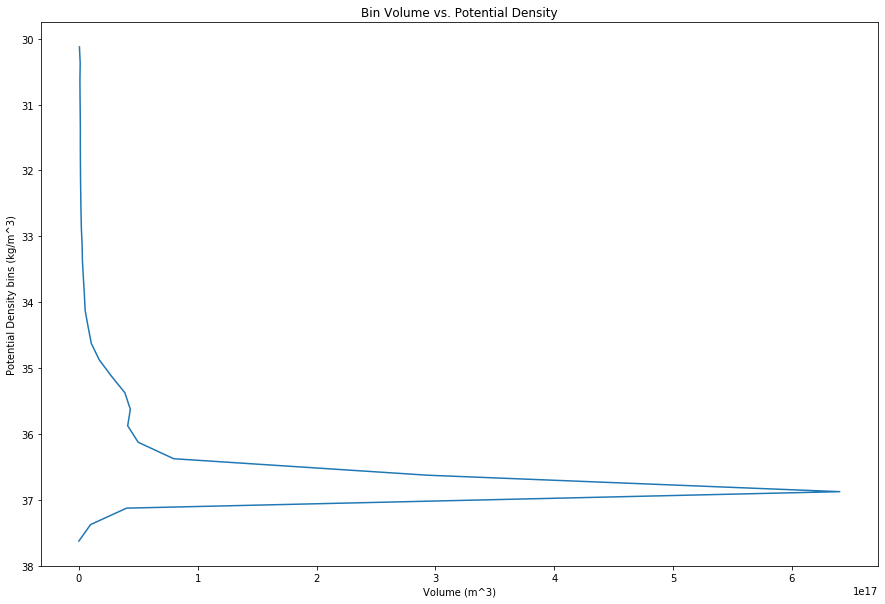

In [12]:
potden_bins = np.arange(30, 38, 0.25)
potden_bins_labels = np.arange(30.125,37.875, 0.25)
dif = ds.isel(time=0).groupby_bins('potential_density',potden_bins, labels = potden_bins_labels)
potdenvolsum = dif.apply(binsum, variable='volcello')
print(potdenvolsum)
plt.figure(figsize = (15,10))
plt.plot(potdenvolsum, potden_bins_labels)
plt.gca().invert_yaxis() 
plt.title('Bin Volume vs. Potential Density')
plt.xlabel('Volume (m^3)')
plt.ylabel('Potential Density bins (kg/m^3)')

<xarray.DataArray 'volcello' (potential_density_bins: 24)>
array([2.158722e+16, 5.639735e+16, 4.513780e+16, 2.002616e+16, 1.946256e+16,
       6.725883e+16, 3.823395e+16, 1.975437e+16, 3.528308e+16, 5.550724e+16,
       2.302098e+16, 4.291527e+16, 4.103892e+16, 2.758231e+16, 2.023404e+16,
       1.850008e+16, 1.373955e+16, 1.327694e+16, 1.089728e+16, 9.510450e+15,
       8.675991e+15, 9.375421e+15, 9.203414e+15, 6.599170e+15], dtype=float32)
Coordinates:
  * potential_density_bins  (potential_density_bins) float64 36.76 ... 36.98
    time                    object 1056-07-02 12:00:00


Text(0, 0.5, 'Potential Density bins (kg/m^3)')

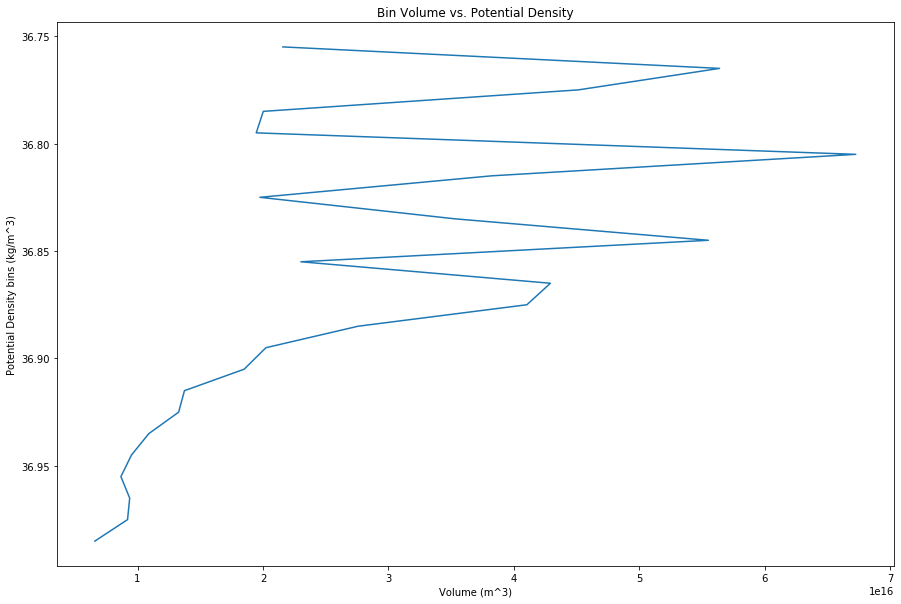

In [13]:
# Try to see the distribution of the huge volume in the potential density bin of 36.75 to 37 kg/m^3
newpotden = np.arange(36.75, 37, 0.01)
newpotden_labels = np.arange(36.755, 36.99, 0.01)
newdif = ds.isel(time=0).groupby_bins('potential_density', newpotden, labels = newpotden_labels)
newpotdenvolsum = newdif.apply(binsum, variable='volcello')
print(newpotdenvolsum)

plt.figure(figsize = (15,10))
plt.plot(newpotdenvolsum, newpotden_labels)
plt.gca().invert_yaxis() 
plt.title('Bin Volume vs. Potential Density')
plt.xlabel('Volume (m^3)')
plt.ylabel('Potential Density bins (kg/m^3)')

In [14]:
newneutralbin = np.arange(27.75, 28.0, 0.01)
newneutralbin_labels = np.arange(27.755, 27.99, 0.01)
# Try to sum the volume in the density class 27.75 to 28
newdifferent = ds.isel(time=0).groupby_bins('neutral_density',newneutralbin, labels = newneutralbin_labels)
newdenvolsum = newdifferent.apply(binsum, variable='volcello')
print(newdenvolsum)

<xarray.DataArray 'volcello' (neutral_density_bins: 24)>
array([1.223687e+16, 1.666635e+16, 1.857793e+16, 2.038962e+16, 2.024433e+16,
       2.802658e+16, 1.906036e+16, 2.359215e+16, 3.750963e+16, 4.779093e+16,
       3.647714e+16, 2.033888e+16, 2.319891e+16, 6.029569e+16, 3.694474e+16,
       2.150990e+16, 2.272456e+16, 5.291647e+16, 3.051670e+16, 2.144014e+16,
       3.957246e+16, 3.589938e+16, 2.357442e+16, 1.807395e+16], dtype=float32)
Coordinates:
  * neutral_density_bins  (neutral_density_bins) float64 27.75 27.77 ... 27.99
    time                  object 1056-07-02 12:00:00


Text(0, 0.5, 'Neutral Density bins (kg/m^3)')

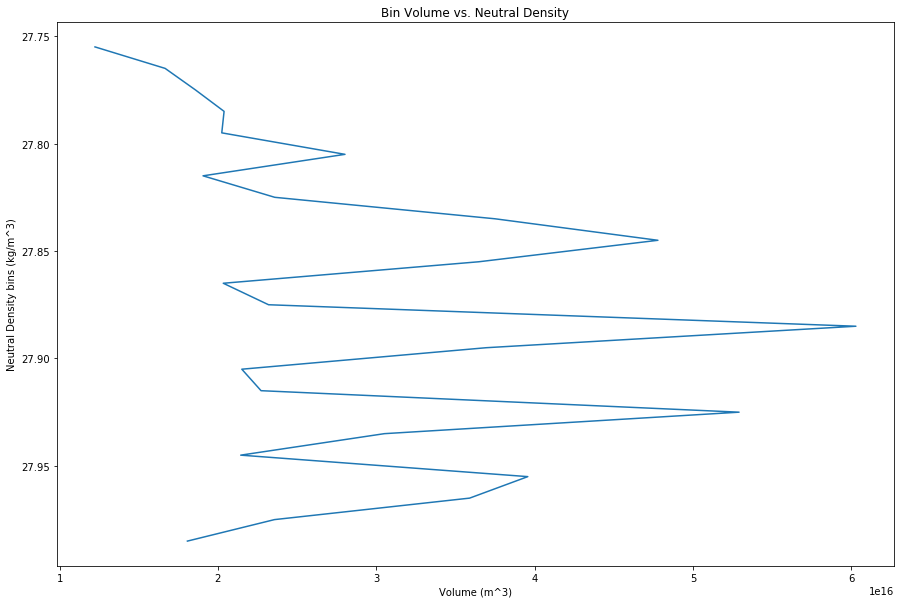

In [15]:
# Explore the huge volume in the neutral density bin of 27.75 to 28 kg/m^3
plt.figure(figsize = (15,10))
plt.plot(newdenvolsum, newneutralbin_labels)
plt.gca().invert_yaxis() 
plt.title('Bin Volume vs. Neutral Density')
plt.xlabel('Volume (m^3)')
plt.ylabel('Neutral Density bins (kg/m^3)')